# General Classification Explanations

**Example.** In this example, we ask how the features which distinguish Versicolour from Setosa irises compare to those which distinguish Versicolour from Virginica irises. (This is analogous to asking how the symptoms which distinguish COVID-19 from the flu compare to those which distinguish COVID-19 from the common cold; however, a sufficient COVID-19 dataset is not publicly available.) We find that petal length is the most important feature. Additionally, petal length is relatively less important, and sepal length relatively more important, for distinguishing Versicolour from Setosa (as opposed to distinguishing Versicolour from Virginia).

**General formulation.** More generally, let $f_c(x_i)$ be the probability that observation $x_i$ belongs to class $c\in C$ according to model $f$. Let $C_+\subset C$ be a set of 'positive classes' and $C_-\subset C$ be a set of 'negative classes'. For a single observation $x_i$, we can ask why our model predicts it comes from a positive class rather than a negative class. For a randomly selected set of observations $X$ from positive classes, we can ask which features best distinguish observations which belong to positive classes from observations which belong to negative classes. Here, the positive class is Versicolour, and the negative class is Setosa or Virginica.

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
from gshap.probability_distance import ProbabilityDistance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import os
import random

np.random.seed(0)
random.seed(0)

# directory for saving figures
# set to `None` to avoid saving
PLOT_DIR = 'plots'

**Model.** We train Scikit-learn's support vector classifier with default settings on the Scikit-learn iris dataset ($n=150$), using a 75%-25% train-test split. The purpose of this dataset is to predict an iris's species (Versicolour, Setosa, or Virginica) based on its petal length, petal width, sepal length, and sepal width.

In [2]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)
clf = SVC(probability=True)
clf.fit(X_train, y_train)
print('Test score: % .4f' % clf.score(X_test, y_test))

Test score:  0.9737


**Sample.** To discover which features distinguish Versicolour from Setosa or Virginica, our set of observations $X$ is a random sample of test observations classified as Versicolour. Note that our analysis will not work if $X$ contains a mixture of iris species. Intuitively, we are asking what features lead our model to believe that $X$ contains only Versicolour irises. If $X$ contains a mixture of iris species, the G-SHAP values will be 0 for all features, indicating that our model does not believe $X$ contains only Versicolour irises.

Sepal length and petal length are of most interest to our analysis. To visualize where our observations fall along these dimensions, we create a scatterplot. The selected observations are highlighted in red.

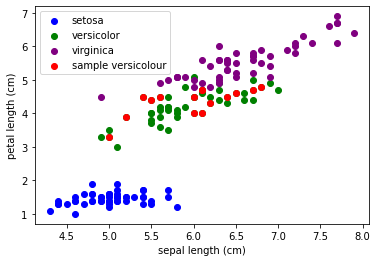

In [3]:
# select Versicolour (class 1)
X = X_test[clf.predict(X_test) == 1]
X = X.reshape((1,-1)) if len(X.shape) == 1 else X

# plot sepal length (feature 0) against petal length (feature 2)
palette = ['blue', 'green', 'purple']
for i in range(3):
    species = iris.data[iris.target==i]
    plt.scatter(species[:,0], species[:,2], c=palette[i], label=iris.target_names[i])
plt.scatter(X[:,0], X[:,2], c='red', label='sample versicolour')
plt.xlabel(iris['feature_names'][0])
plt.ylabel(iris['feature_names'][2])
plt.legend()
if PLOT_DIR is not None:
    plt.savefig(os.path.join(PLOT_DIR, 'iris_scatter.png'))
plt.show()

**G-SHAP values.** We compute the G-SHAP values, where $g$ measures the probability that every observation in set $X$ belongs to a positive class given that every observation belongs to a positive class or every observation belongs to a negative class.

\begin{equation}
g(f,X,\Omega) = \frac{\prod_i \sum_{c\in C_+} f_c(x_i)}{\prod_i \sum_{c\in C_+} f_c(x_i) + \prod_i \sum_{c\in C_-} f_c(x_i)}
\end{equation}

Where the additional arguments to $g$ are the sets of positive and negative classes; $\Omega=\{C_+,C_-\}$.

Note that traditional SHAP values are a specific instance of $g(f,X,\Omega)$ in which set $X$ contains a single observation $x_i$, the set of positive classes is the model's classification of $x_i$; $C_+=\{arg\,max_{c\in C} f_c(x_i)\}$, and the negative classes are the complement of the positive classes $C_-=C\setminus C_+$. Also note that, while our generalized function $g(f,X,\Omega)$ uses only two subsets of classes, $C_+$ and $C_-$, it easily extends to accommodate any number of subsets.

In our example, $g$ measures the probability that every iris in this sample is a Versicolour, given that every iris in this sample is a Versicolour or every iris in this sample is a Setosa. Specifically, the set of positive classes $C_+$ is $\{\text{Versicolour}\}$, and the set of negative classes $C_-$ is $\{\text{Setosa}\}$.

\begin{equation}
g(f,X,\Omega) 
= \frac{\prod_i f_{\text{Versicolour}}(x_i)}
{\prod_i f_{\text{Versicolour}}(x_i) + \prod_i f_{\text{Setosa}}(x_i)}
\end{equation}

In [4]:
# Versicolour (1) versus Setosa (0)
pos_distribution = lambda y_pred: y_pred[:,1]
neg_distribution = lambda y_pred: y_pred[:,0]
g = ProbabilityDistance(pos_distribution, neg_distribution)
explainer_10 = gshap.KernelExplainer(clf.predict_proba, X_train, g)
gshap_values_10 = explainer_10.gshap_values(X, nsamples=10000)

Similarly, to discover which features distinguish Versicolour from Virginica, $C_-$ is $\{\text{Virginica}\}$. As before, $C_+=\{\text{Versicolour}\}$.

In [5]:
# Versicolour (1) versus Virginica (2)
neg_distribution = lambda y_pred: y_pred[:,2]
g = ProbabilityDistance(pos_distribution, neg_distribution)
explainer_12 = gshap.KernelExplainer(clf.predict_proba, X_train, g)
gshap_values_12 = explainer_12.gshap_values(X, nsamples=10000)

**Interpretation.** For interpretation, we compare our Versicolour sample $X$ to a background dataset $Z$ (the shuffled training data) in terms of $g$. For the Versicolour-Setosa comparison, our support vector classifier correctly predicts a 100\% chance that our sample contains only Versicolour, as opposed to only Setosa. It also predicts a 65% chance that our background dataset contains only Versicolour, as opposed to only Setosa. Each G-SHAP value $\phi_g^j$ is the number of percentage points of this difference (35 percentage points) explained by feature $j$.

For general classification explanations more broadly, our model predicts that each observation in our sample belongs to a positive class, rather than a negative class, with probability $Pr_X$. It also predicts that each observation in the background dataset comes from a positive class, rather than a negative class, with probability $Pr_Z$. Each G-SHAP value $\phi_g^j$ is the number of percentage points of this difference $Pr_X-Pr_Z$ explained by feature $j$.

In [6]:
g_comparison, g_background = explainer_10.compare(X, bootstrap_samples=10000)
print('Probability that our sample belongs to a positive class: %.4f' % g_comparison)
print('Probability that the background data belongs to a positive class: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values_10.sum())

Probability that our sample belongs to a positive class: 1.0000
Probability that the background data belongs to a positive class: 0.6296
Sum of G-SHAP values: 0.3695


We interpret the G-SHAP values for the Versicolour-Virginica comparison similarly.

In [7]:
g_comparison, g_background = explainer_12.compare(X, bootstrap_samples=10000)
print('Probability that our sample belongs to a positive class: %.4f' % g_comparison)
print('Probability that the background data belongs to a positive class: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values_12.sum())

Probability that our sample belongs to a positive class: 1.0000
Probability that the background data belongs to a positive class: 0.3990
Sum of G-SHAP values: 0.6024


**Results.** We plot our results, normalizing the G-SHAP values to sum to 1 for both comparisons (Versicolour-Setosa and Versicolour-Virginica). We find that petal length is the most important feature. Additionally, petal length is relatively less important, and sepal length relatively more important, for distinguishing Versicolour from Setosa (as opposed to distinguishing Versicolour from Virginia).

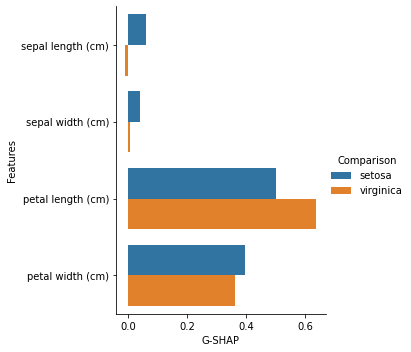

In [8]:
df = pd.DataFrame({
    'Features': iris['feature_names']*2,
    'G-SHAP': list(gshap_values_10/gshap_values_10.sum()) + list(gshap_values_12/gshap_values_12.sum()), 
    'Comparison': [iris['target_names'][0]]*4 + [iris['target_names'][2]]*4
})
sns.catplot(
    x='G-SHAP', 
    y='Features', 
    hue='Comparison', 
    data=df, 
    kind='bar',
    orient='h'
)
if PLOT_DIR is not None:
    plt.savefig(os.path.join(PLOT_DIR, 'iris_gshap.png'))
plt.show()

In [9]:
df

,Features,G-SHAP,Comparison
0,sepal length (cm),0.059266,setosa
1,sepal width (cm),0.041194,setosa
2,petal length (cm),0.502755,setosa
3,petal width (cm),0.396785,setosa
4,sepal length (cm),-0.008588,virginica
5,sepal width (cm),0.007735,virginica
6,petal length (cm),0.637756,virginica
7,petal width (cm),0.363097,virginica
